# thal2 2:3 2k Bifurcation Diagrams

# Inits

## Imports

In [1]:
import sys; sys.path.insert(0, '..') # add parent folder path where lib folder is
# user-defined
import nmCoupling as nm
# import nmCoupling_old as nm
import response as rp

import thal2 as t2

from lib.util import (get_phase, freq_est,follow_phase_diffs,follow_phase_diffs_del,
                        follow_phase_diffs_u,follow_phase_diffs_u_del,
get_smallest_eps,get_largest_eps, get_es_min, get_es_max)

from lib.rhs import _redu_c2,_full, _redu_full, _full, _full_mono_rhs

from lib.plot_util import (add_diagram_1d_scatter, quick_plot_combined, 
                            draw_quick_plot_f, add_diagram_1d_del_scatter)


import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import sympy as sym

from scipy.signal import find_peaks
from scipy.optimize import root,bisect
from copy import deepcopy
import os

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

nmc = nm.nmCoupling
rsp = rp.Response

## Dicts

In [2]:
kw_sim = {'rtol':1e-9,'atol':1e-9,'method':'LSODA'}

In [3]:
pd1 = {'gL':0.05,'gna':3,'gk':5,
       'gt':5,'eL':-70,'ena':50,
       'ek':-90,'et':0,'esyn':0,
       'c':1,'alpha':3,'beta':2,
       'sigmat':0.8,'vt':-20,
       'ib':8.5,'del':0,'om':1,'om_fix':1}

In [4]:
# default period must be 2*np.pi
kws1 = {'var_names':['v','h','r','w'],
        'pardict':pd1,
        'rhs':t2.rhs,
        'coupling':t2.coupling,
        'init':np.array([-.64,0.71,0.25,0,6]),
        'TN':20000,
        'trunc_order':1,
        'z_forward':False,
        'i_forward':[False,True,False,False,False,False],
        'i_bad_dx':[False,True,False,False,False,False],
        'max_iter':50,
        'rtol':1e-12,
        'atol':1e-12,
        'rel_tol':1e-9,
        'save_fig':False,
        'lc_prominence':.05,
        'factor':1}

## Defs

In [5]:
#### es_min,phi0 = get_es_min(data_bs_list,data_bu_list)
def get_monodromy_full(es_min,phi0,a,b,mname='',tol=1e-6,recompute=False):
    """
    es_min: minimum epsilon to use
    a: nmCoupling object
    b: het. parameter.
    mnamei are the model names to save the monodromy matrix and related calculations
    """    

    kw_b = {'a':a,'b':b,'recompute':recompute,'bifdir':'bif1d_thal2/','_full_rhs':_full}
    print('es_min,phi0',es_min,phi0)
    # the _u function has the ability to save and load Y values
    _,Y = follow_phase_diffs(**dict(phi0=phi0,eps_init=es_min,eps_final=es_min-.01,deps=-1),max_time=10000,tol=tol,return_point=True,**kw_b)

    print('Y',Y)
    # define parameters for finding monodromy of full system
    pd_vdp_thal = {**a.system1.pardict,**a.system2.pardict}
    pd_vdp_thal['b']=b
    pd_vdp_thal['a']=a
    
    pd_vdp_thal['eps']=es_min
    # print(pd1['del0'])
    
    # default period must be 2*np.pi
    kws_vdp_thal = {'var_names':['v0','h0','r0','w0','v1','h1','r1','w1'],
                    'pardict':pd_vdp_thal,
                    'rhs':_full_mono_rhs,
                    'coupling':lambda x: 0*x,
                    'init':Y, # from above
                    'use_init':True, # use init for direct LC calculation
                    'TN':50000,
                    'mode':'none', # forces not normalizing period.
                    'rtol_lc':1e-10,
                    'atol_lc':1e-10,
                    'trunc_order':0,
                    'z_forward':False,
                    'i_forward':False,
                    'i_bad_dx':[False,True,False,False,False,False],
                    'save_fig':False,
                    'max_iter':50,
                    'max_time_lc':5000,
                    'tol_root_lc':1e-8,
                    'halt_after_mono':True}

    m1 = rsp(idx='',model_name=mname,**kws_vdp_thal)

    return m1

In [6]:
kw_bif = {'method':'LSODA','dense_output':True,'rtol':1e-9,'atol':1e-9}

In [7]:
x_temp = np.linspace(-np.pi,3*np.pi,500)

In [8]:
ss,dss=np.linspace(0,2,100,retstep=True)

In [9]:
def compute_sol_all(a,eps,phi0,b,T=2000,dt=.01,c_sign=1):
    """
    only for use in jupyter
    """
    t = np.arange(0,T,dt)
    args = {'args':(a,eps,b,'val',c_sign), 't_eval':t,**kw_sim}

    y0a = a.system1.lc['dat'][int((phi0/(2*np.pi)) * a.system1.TN),:]
    y0b = a.system2.lc['dat'][int((0/(2*np.pi)) * a.system2.TN),:]
    y0 = np.array([y0a,y0b]).flatten()
    #a.system1.pardict['del0'] = b

    tot = 0
    for i in range(len(a.het_coeffs)):
        tot += eps**i*b**(i+1)*a.het_coeffs[i]
    a.system1.pardict['del0'] = tot
    print(a.system1.pardict['del0'])
    #print(pd1['del0'])
    
    solf = solve_ivp(_full,[0,t[-1]], y0, **args)

    args['args'] = (a,eps,b,1)
    solr_o1 = solve_ivp(_redu_c2,[0,t[-1]], [phi0],**args)
    
    args['args'] = (a,eps,b,2)
    solr_o2 = solve_ivp(_redu_c2,[0,t[-1]], [phi0],**args)
    
    #args['args'] = (a,eps,b,3)
    #solr_o3 = solve_ivp(_redu_c2,[0,t[-1]], [phi0],**args)
    
    #args['args'] = (a,eps,b,4)
    #solr_o4 = solve_ivp(_redu_c2,[0,t[-1]], [phi0],**args)

    return solf, solr_o1, solr_o2#, solr_o3, solr_o4


def load_sol_all(a,eps,phi0,b,T,c_sign=1,dt=.01,path_loc='sols_temp/',recompute=True):
    if (not os.path.exists(path_loc)):
        os.makedirs(path_loc)

    if c_sign == 1:
        fname_f = 'sol_f_thal2_nm={}{}_eps={}_b={}_T={}_phi0={}.dat'.format(a._n[1],a._m[1],eps,b,T,phi0)
        fname_r = 'sol_r_thal2_nm={}{}_eps={}_b={}_T={}_phi0={}.dat'.format(a._n[1],a._m[1],eps,b,T,phi0)
    else:
        fname_f = 'sol_f_thal2_nm={}{}_eps={}_b={}_T={}_phi0={}_csgn={}.dat'.format(a._n[1],a._m[1],eps,b,T,phi0,c_sign)
        fname_r = 'sol_r_thal2_nm={}{}_eps={}_b={}_T={}_phi0={}_csgn={}.dat'.format(a._n[1],a._m[1],eps,b,T,phi0,c_sign)

    fname_f = path_loc + fname_f
    fname_r = path_loc + fname_r

    print('full',fname_f)
    print('redu',fname_r)
    
    file_dne = not(os.path.isfile(fname_f))
    file_dne += not(os.path.isfile(fname_r))

    if file_dne or recompute:
        solf, solr_o1, solr_o2 = compute_sol_all(a,eps,phi0,b,T=T,dt=dt,c_sign=c_sign)

        # phase of full model
        ta, pha = get_phase(solf.t,solf.y.T[:,:4], skipn=200,system1=a.system1)
        tb, phb = get_phase(solf.t,solf.y.T[:,4:], skipn=200,system1=a.system2)

        dat1 = np.zeros([len(ta),2])
        dat1[:,0] = ta
        dat1[:,1] = np.mod(pha - a.om*phb,2*np.pi)

        dat2 = np.zeros([len(solr_o1.t),5])
        dat2[:,0] = solr_o1.t
        dat2[:,1] = solr_o1.y[0]
        dat2[:,2] = solr_o2.y[0]

        np.savetxt(fname_f,dat1)
        np.savetxt(fname_r,dat2)

    else:
        dat1 = np.loadtxt(fname_f)
        dat2 = np.loadtxt(fname_r)
    return dat1, dat2

## Initialize Response Functions

In [10]:
system1 = rsp(idx=0,model_name='thal0_85_2k',**kws1)
system2 = rsp(idx=1,model_name='thal1_85_2k',**kws1)

mkdir ./data/thal0_85_2k/
* Loading LC data...
self.T 6.283185307179586 omfix 0.990198152249508
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.024354475778909167
* Loading g symbolic...
* Computing g...
* Loading heterogeneous terms...
* Computing z...
* Computing i...
mkdir ./data/thal1_85_2k/
* Loading LC data...
self.T 6.283185307179586 omfix 0.990198152249508
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.024354475778909167
* Loading g symbolic...
* Computing g...
* Loading heterogeneous terms...
* Computing z...
* Computing i...


# Initialize Coupling 2:3

In [11]:
het_coeffs = [1,2000]

In [12]:
#recompute_list = ['k_thal0_85','k_thal1_85','h_thal0_85','h_thal1_85', 'h_data_thal0_85','h_data_thal1_85', 'p_data_thal0_85','p_data_thal1_85','p_thal0_85','p_thal1_85']
# recompute_list = ['k_thal0_85','k_thal1_85']
nm_tup = (2,3)
recompute_list = []
kw_nm = {'system1':system1,'system2':system2,'_n':('om0',nm_tup[0]),'_m':('om1',nm_tup[1]),
         'NH':1024,'save_fig':False, 'recompute_list':recompute_list,
         'het_coeffs':het_coeffs, # [eps, eps^2, etc]
        }
a = nm.nmCoupling(**kw_nm)
nm_val = str(nm_tup[0])+str(nm_tup[1])

Initializing 23 Coupling...
pfactor 30
* Loading p symbolic...
* Loading p symbolic...
p order=0
p order=0
* Loading H symbolic...
* Loading H symbolic...
* Loading H thal0_85_2k, order=0...
* Loading H thal1_85_2k, order=0...
* Loading H thal0_85_2k, order=1...
* Loading H thal1_85_2k, order=1...


### Plot 1par eps

<Axes: >

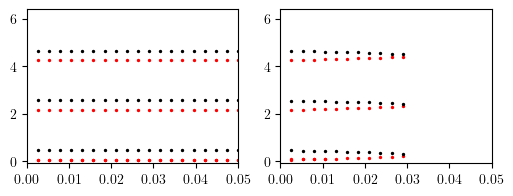

In [13]:
etup = (.001,.25,100)

fig,axs = plt.subplots(1,2,figsize=(6,2))
kw_diagram = dict(a=a,b=.004,eps_tup=(0,.05,20),rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

### Plot 1par del

<Axes: >

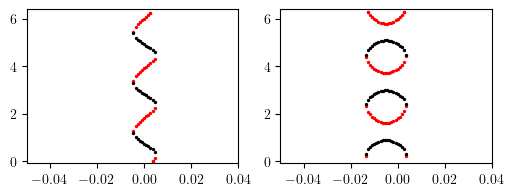

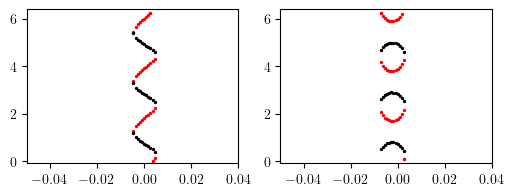

In [14]:
dtup12 = (-.05,.04,100)

fig,axs = plt.subplots(1,2,figsize=(6,2))
kw_diagram = dict(a=a,eps=0.05,del_tup=dtup12,rhs=_redu_c2)
add_diagram_1d_del_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_del_scatter(axs[1],miter=2,**kw_diagram)

fig,axs = plt.subplots(1,2,figsize=(6,2))
kw_diagram = dict(a=a,eps=0.1,del_tup=dtup12,rhs=_redu_c2)
add_diagram_1d_del_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_del_scatter(axs[1],miter=2,**kw_diagram)

#for i in range(4):
#    draw_quick_plot_f(axs[i],data_b1_list,a)

## EPS VARY

In [15]:
kw_b = {'a':a,'b':0,'recompute':False,'bifdir':'bif1d_thal2_2k/','_full_rhs':_full}
fname_bs = kw_b['bifdir']+'hyper_thal2_'+nm_val+'_b={}_s.txt'
fname_bu = kw_b['bifdir']+'hyper_thal2_'+nm_val+'_b={}_u.txt'

In [16]:
mname_list = ['thal2_'+nm_val+'_b'+str(i)+'={}' for i in range(5)]

In [17]:
b_vals_full = []
e_vals_full = [] # save min eps values for all diagrams
e_hi_full = [] # save max eps values for all diagrams

## monodromy calculations
e_vals_mono_min = [] # save eps values at min monodromy
eigenvalues_min_all = []
b_min_all = []

e_vals_mono_max = [] # save eps values at max monodromy
eigenvalues_max_all = []
b_max_all = []

### b=0.004

#### Branches eps stable

In [18]:
b=0.004
kw_b['recompute'] = False
kw_b['b'] = b

In [19]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [dict(phi0=2.5,eps_init=0.02,eps_final=0,deps=-.001),
            dict(phi0=2.5,eps_init=0.019,eps_final=0.2,deps=.001)]

In [20]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 2.5
phi init 2.5


In [21]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [22]:
# _,Yinit = follow_phase_diffs(c_sign=-1,**dict(phi0=4.01,eps_init=0.01,eps_final=0,deps=-2),tol=1e-8,max_iter=100,return_point=True,**kw_b)

In [23]:
# hase_diffs_u_init=4.0_nm=23_b=0.003_ei=0.005_ef=0_de=-2.txt
# phase_diffs_u_pt_init=4.0_nm=23_b=0.003_ei=0.005_ef=0_de=-2.txt

kw_b['b'] = 0.003
da,Yinit = follow_phase_diffs_u(**dict(phi0=4.0,eps_init=0.005,eps_final=0,deps=-2),tol=1e-7,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = 0.004
da,Yinit = follow_phase_diffs_u(**dict(phi0=4.0,eps_init=0.005,eps_final=0,deps=-2),use_point=Yinit,tol=1e-7,max_iter=100,return_point=True,**kw_b)
print(da)

phi init 4.0
phase_diffs_u_init=4.0_nm=23_b=0.003_ei=0.005_ef=0_de=-2.txt
phase_diffs_u_pt_init=4.0_nm=23_b=0.003_ei=0.005_ef=0_de=-2.txt
[5.00000000e-03 3.13801264e+00 3.13801264e+00 3.13801264e+00 4.16396181e+00 6.25355142e+00 2.06035618e+00]
phi init 4.0
phase_diffs_u_init=4.0_nm=23_b=0.004_ei=0.005_ef=0_de=-2.txt
phase_diffs_u_pt_init=4.0_nm=23_b=0.004_ei=0.005_ef=0_de=-2.txt
[0.005      3.13801264 3.13801264 3.13801264 4.27609004 0.08249434 2.1724844 ]


In [24]:
kw_b['recompute'] = False
kw_b['b'] = b

In [25]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [dict(phi0=4.,eps_init=0.005,eps_final=0,deps=-.001),
            dict(phi0=4.,eps_init=0.0049,eps_final=0.2,deps=.005),
           ]

In [26]:
data_bu_list = []
# Y=Yinit
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 4.0
phi init 4.0


In [27]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

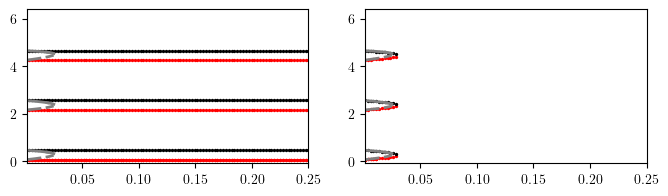

In [28]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys max

In [29]:
# get min eps
es_max,phi0 = get_es_max(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_max_temp = []
for i in range(5):
    ee = es_max-0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_max_temp.append(ee)

b_max_all.append(b)
eigenvalues_max_all.append(eigenvalues_temp)
e_vals_mono_max.append(es_max_temp)
#m1b = get_monodromy_full(es_max+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_max+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.025000000000000005 2.394532962046016
phi init 2.394532962046016
Y [-1.08192073e-01  2.25733523e-01  9.24745518e-02  4.05680380e-01 -6.13235709e-01  4.54507478e-01  9.65402728e-02  5.33582666e-03  6.24829018e+00]
mkdir ./data/thal2_23_b0=0.004/
* Loading LC data...
self.T 6.248290189214528
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0005608539804928508
es_min,phi0 0.024500000000000004 2.394532962046016
phi init 2.394532962046016
Y [-1.09311879e-01  2.27908427e-01  9.23763999e-02  4.01906742e-01 -3.55905740e-01  6.37833738e-01  9.39208413e-02  9.86284206e-06  6.24896282e+00]
mkdir ./data/thal2_23_b1=0.004/
* Loading LC data...
self.T 6.248962826522799
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0006895209306007161
es_min,phi0 0.024000000000000004 2.394532962046016
phi init 2.394532962046016
Y [-1.09349059e-01  2.22495731e-01  9.23859982e-02  4.08311151e-01 -3.56184970e-01  6.37985093e-01  9.39454263e-02

In [30]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(0)

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=0.003

#### Sim

In [31]:
# a=a;T=5000;b=0.003;e=.11;phi0 = 4
# dat1,dat2=load_sol_all(a=a,eps=e,phi0=phi0,b=b,T=T,recompute=False)
# t1=dat1[:,0];y=dat1[:,1]
# t2=dat2[:,0];so1=dat2[:,1];so2=dat2[:,2]

# fig,axs = plt.subplots(figsize=(4,2))

# axs.scatter(t1,y,s=1,alpha=.5,color='black')

# axs.plot(t2,np.mod(so1,2*np.pi),label='o1')
# axs.plot(t2,np.mod(so2,2*np.pi),label='o2')

# axs.set_ylim(-.5,2*np.pi+.5)
# axs.legend()

#### Branches eps stable

In [32]:
b=0.003
kw_b['recompute'] = False
kw_b['b'] = b

In [33]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [dict(phi0=2.5,eps_init=0.02,eps_final=0,deps=-.005),
            dict(phi0=2.5,eps_init=0.019,eps_final=0.2,deps=.01)]

In [34]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 2.5
phi init 2.5


In [35]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [36]:
kw_b['recompute'] = False
kw_b['b'] = b

In [37]:
# _,Yinit = follow_phase_diffs(c_sign=-1,**dict(phi0=4.01,eps_init=0.01,eps_final=0,deps=-2),tol=1e-8,max_iter=100,return_point=True,**kw_b)

In [38]:
_,Yinit = follow_phase_diffs_u(**dict(phi0=4.,eps_init=0.005,eps_final=0,deps=-2),tol=1e-7,max_iter=100,return_point=True,**kw_b)

phi init 4.0
phase_diffs_u_init=4.0_nm=23_b=0.003_ei=0.005_ef=0_de=-2.txt
phase_diffs_u_pt_init=4.0_nm=23_b=0.003_ei=0.005_ef=0_de=-2.txt


In [39]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [dict(phi0=4.277,eps_init=0.005,eps_final=0,deps=-.001),
            dict(phi0=4.277,eps_init=0.0049,eps_final=0.2,deps=.005),
           ]

In [40]:
data_bu_list = []
# Y=Yinit
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 4.277
phi init 4.277


In [41]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

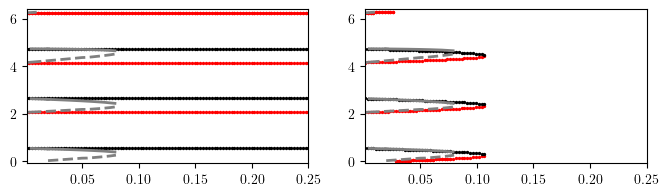

In [42]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys max

In [43]:
# get min eps
es_max,phi0 = get_es_max(data_bs_list,data_bu_list)

eigenvalues_temp = []
es_max_temp = []
for i in range(5):
    ee = es_max-0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_max_temp.append(ee)

b_max_all.append(b)
eigenvalues_max_all.append(eigenvalues_temp)
e_vals_mono_max.append(es_max_temp)

es_min,phi0 0.07989999999999998 2.2849796308169483
phi init 2.2849796308169483
Y [-1.13382513e-01  2.27814728e-01  8.91982485e-02  3.97525610e-01 -3.76523968e-01  6.45960659e-01  9.04474244e-02  1.14792292e-05  6.17625128e+00]
mkdir ./data/thal2_23_b0=0.003/
* Loading LC data...
self.T 6.172507042105371
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0016955122994161639
es_min,phi0 0.07939999999999998 2.2849796308169483
phi init 2.2849796308169483
Y [-1.13345362e-01  2.28045892e-01  8.92266339e-02  3.97287096e-01 -3.77755652e-01  6.46449340e-01  9.04827233e-02  1.16017726e-05  6.17685708e+00]
mkdir ./data/thal2_23_b1=0.003/
* Loading LC data...
self.T 6.173110050100946
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.001976869083318553
es_min,phi0 0.07889999999999998 2.2849796308169483
phi init 2.2849796308169483
Y [-0.1096549   0.22946979  0.08958916  0.39971676 -0.61818948  0.41867669  0.09235678  0.0080262   6.17746351]


In [44]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(0)

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=0.002

#### Branches eps stable

In [45]:
b=0.002
kw_b['recompute'] = False
kw_b['b'] = b

In [46]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [dict(phi0=2.5,eps_init=0.1,eps_final=0,deps=-.01),
            dict(phi0=2.5,eps_init=0.099,eps_final=0.2,deps=.01)]

In [47]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 2.5
phi init 2.5


In [48]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [49]:
kw_b['recompute'] = False
kw_b['b'] = b

In [50]:
_,Yinit = follow_phase_diffs_u(**dict(phi0=4,eps_init=0.01,eps_final=0,deps=-2),tol=1e-7,max_iter=100,return_point=True,**kw_b)

phi init 4
phase_diffs_u_init=4_nm=23_b=0.002_ei=0.01_ef=0_de=-2.txt
phase_diffs_u_pt_init=4_nm=23_b=0.002_ei=0.01_ef=0_de=-2.txt


In [51]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [dict(phi0=4,eps_init=0.01,eps_final=0,deps=-.002),
            dict(phi0=4,eps_init=0.0099,eps_final=0.2,deps=.01),
           ]

In [52]:
data_bu_list = []
# Y=Yinit
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 4
phi init 4


In [53]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

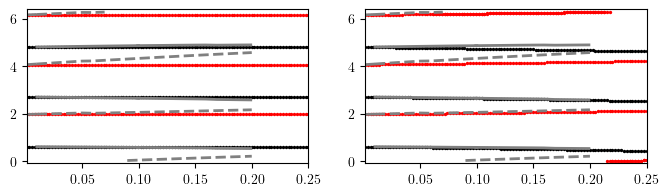

In [54]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

In [55]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(0)

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-0.003

#### Branches eps stable

In [56]:
b=-0.003
kw_b['recompute'] = False
kw_b['b'] = b

In [57]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [dict(phi0=2.5,eps_init=0.1,eps_final=0,deps=-.01),
            dict(phi0=2.5,eps_init=0.099,eps_final=0.2,deps=.01)]

In [58]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 2.5
phi init 2.5


In [59]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [60]:
kw_b['recompute'] = False
kw_b['b'] = b

In [61]:
_,Yinit = follow_phase_diffs_u(**dict(phi0=3.8,eps_init=0.01,eps_final=0,deps=-2),tol=1e-7,max_iter=100,return_point=True,**kw_b)

phi init 3.8
phase_diffs_u_init=3.8_nm=23_b=-0.003_ei=0.01_ef=0_de=-2.txt
phase_diffs_u_pt_init=3.8_nm=23_b=-0.003_ei=0.01_ef=0_de=-2.txt


In [62]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [dict(phi0=4,eps_init=0.01,eps_final=0,deps=-.002),
            dict(phi0=4,eps_init=0.0099,eps_final=0.2,deps=.01),
           ]

In [63]:
data_bu_list = []
# Y=Yinit
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 4
phi init 4


In [64]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

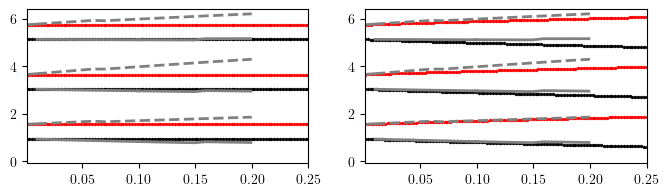

In [65]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

In [66]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(0)

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-0.004

#### Branches eps stable

In [67]:
b=-0.004
kw_b['recompute'] = False
kw_b['b'] = b

In [68]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [dict(phi0=2.5,eps_init=0.1,eps_final=0,deps=-.01),
            dict(phi0=2.5,eps_init=0.099,eps_final=0.2,deps=.01)]

In [69]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 2.5
phi init 2.5


In [70]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [71]:
kw_b['recompute'] = False
kw_b['b'] = b

In [72]:
_,Yinit = follow_phase_diffs_u(**dict(phi0=3.8,eps_init=0.01,eps_final=0,deps=-2),tol=1e-7,max_iter=100,return_point=True,**kw_b)

phi init 3.8
phase_diffs_u_init=3.8_nm=23_b=-0.004_ei=0.01_ef=0_de=-2.txt
phase_diffs_u_pt_init=3.8_nm=23_b=-0.004_ei=0.01_ef=0_de=-2.txt


In [73]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [dict(phi0=4,eps_init=0.01,eps_final=0,deps=-.002),
            dict(phi0=4,eps_init=0.0099,eps_final=0.2,deps=.01),
           ]

In [74]:
data_bu_list = []
# Y=Yinit
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 4
phi init 4


In [75]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

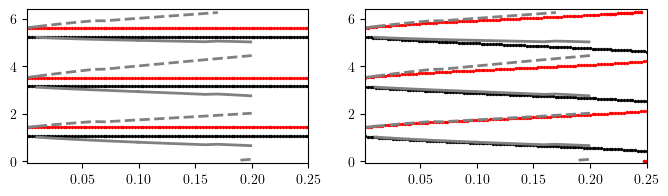

In [76]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

In [77]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(0)

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-0.005

#### Branches eps stable

In [78]:
b=-0.005
kw_b['recompute'] = False
kw_b['b'] = b

In [79]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [
    dict(phi0=2.5,eps_init=0.02,eps_final=0,deps=-.001),
    dict(phi0=2.5,eps_init=0.1,eps_final=0,deps=-.01),
    dict(phi0=2.5,eps_init=0.099,eps_final=0.2,deps=.01)
]

In [80]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 2.5
phi init 2.5
phi init 2.5


In [81]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [82]:
kw_b['recompute'] = False
kw_b['b'] = b

In [83]:
_,Yinit = follow_phase_diffs_u(**dict(phi0=4,eps_init=0.025,eps_final=0,deps=-2),tol=1e-7,max_iter=100,return_point=True,**kw_b)

phi init 4
phase_diffs_u_init=4_nm=23_b=-0.005_ei=0.025_ef=0_de=-2.txt
phase_diffs_u_pt_init=4_nm=23_b=-0.005_ei=0.025_ef=0_de=-2.txt


In [84]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [dict(phi0=4,eps_init=0.025,eps_final=0,deps=-.002),
            dict(phi0=4,eps_init=0.024,eps_final=0.2,deps=.01),
           ]

In [85]:
data_bu_list = []
# Y=Yinit
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 4
phi init 4


In [86]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

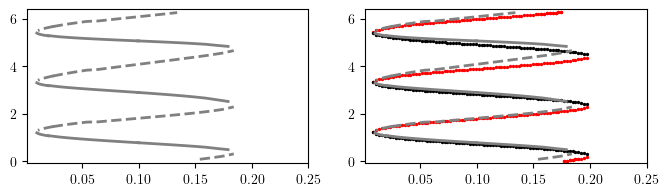

In [87]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys min

In [88]:
# get min eps
es_min,phi0 = get_es_min(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_min_temp = []
for i in range(5):
    ee = es_min+0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_min_temp.append(ee)

b_min_all.append(b)
eigenvalues_min_all.append(eigenvalues_temp)
e_vals_mono_min.append(es_min_temp)
#m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.009999999999999992 3.295775099860192
phi init 3.295775099860192
Y [-0.10803072  0.2360609   0.09279778  0.39377846 -0.59182099  0.18582161  0.09024992  0.06954418  6.26754796]
mkdir ./data/thal2_23_b0=-0.005/
* Loading LC data...
self.T 6.267547993231008
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0001403796616598881
es_min,phi0 0.010499999999999992 3.295775099860192
phi init 3.295775099860192
Y [-0.10796828  0.23323584  0.09274081  0.39709388 -0.59524604  0.19165266  0.09026309  0.06591902  6.26674743]
mkdir ./data/thal2_23_b1=-0.005/
* Loading LC data...
self.T 6.266747469011026
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.00021605186242822376
es_min,phi0 0.010999999999999992 3.295775099860192
phi init 3.295775099860192
Y [-1.08190843e-01  2.29019214e-01  9.27956783e-02  4.01782929e-01 -5.02117825e-01  6.38424968e-01  9.73720610e-02  1.28429700e-04  6.26595364e+00]
mkdir ./data/thal2_23_b2=-0.005/
* 

#### Monodromys max

In [89]:
# get min eps
es_max,phi0 = get_es_max(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_max_temp = []
for i in range(5):
    ee = es_max-0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_max_temp.append(ee)

b_max_all.append(b)
eigenvalues_max_all.append(eigenvalues_temp)
e_vals_mono_max.append(es_max_temp)
#m1b = get_monodromy_full(es_max+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_max+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.18400000000000002 2.2820416198860993
phi init 2.2820416198860993
Y [-0.11201717  0.2255834   0.08451534  0.40175574 -0.61886954  0.37004471  0.08440536  0.01313691  6.05895212]
mkdir ./data/thal2_23_b0=-0.005/
* Loading LC data...
self.T 6.267547993231008
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0001403796616598881
es_min,phi0 0.18350000000000002 2.2820416198860993
phi init 2.2820416198860993
Y [-0.11203257  0.223815    0.08450311  0.40388125 -0.61881846  0.36924285  0.0843849   0.01323835  6.05935177]
mkdir ./data/thal2_23_b1=-0.005/
* Loading LC data...
self.T 6.266747469011026
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.00021605186242822376
es_min,phi0 0.18300000000000002 2.2820416198860993
phi init 2.2820416198860993
Y [-1.20057657e-01  2.25556789e-01  8.40313697e-02  3.92559740e-01 -4.00083177e-01  6.50989521e-01  8.32455286e-02  1.47732111e-05  6.05975133e+00]
mkdir ./data/thal2_23_b2=-0.005/

In [90]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-0.01

#### Branches eps stable

In [91]:
b=-0.01
kw_b['recompute'] = False
kw_b['b'] = b

In [92]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [dict(phi0=2.5,eps_init=0.05,eps_final=0,deps=-.002),
            dict(phi0=2.5,eps_init=0.0499,eps_final=0.2,deps=.002)]

In [93]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 2.5
phi init 2.5


In [94]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [95]:
kw_b['b'] = -.005
_,Yinit = follow_phase_diffs_u(**dict(phi0=4,eps_init=0.025,eps_final=0,deps=-2),tol=1e-7,max_iter=100,return_point=True,**kw_b)

phi init 4
phase_diffs_u_init=4_nm=23_b=-0.005_ei=0.025_ef=0_de=-2.txt
phase_diffs_u_pt_init=4_nm=23_b=-0.005_ei=0.025_ef=0_de=-2.txt


In [96]:
kw_b['recompute'] = False
kw_b['b'] = b

In [97]:
# # 5.29025505e+00 1.06989847e+00 3.19035262e+00
# _,Yinit = follow_phase_diffs_u(**dict(phi0=3.4,eps_init=0.03,eps_final=0,deps=-2),tol=1e-7,max_iter=100,return_point=True,**kw_b)

In [98]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [dict(phi0=4,eps_init=0.03,eps_final=0,deps=-.002),
            dict(phi0=4,eps_init=0.0299,eps_final=0.2,deps=.002),
           ]

In [99]:
data_bu_list = []
# Y=Yinit
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 4
phi init 4


In [100]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

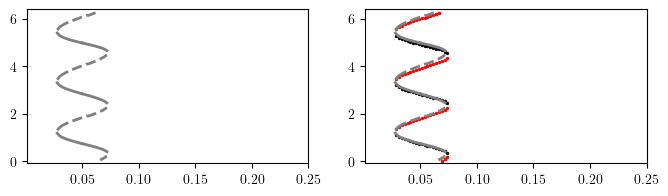

In [101]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys min

In [102]:
# get min eps
es_min,phi0 = get_es_min(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_min_temp = []
for i in range(5):
    ee = es_min+0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_min_temp.append(ee)

b_min_all.append(b)
eigenvalues_min_all.append(eigenvalues_temp)
e_vals_mono_min.append(es_min_temp)
#m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.027999999999999983 3.2994778228471056
phi init 3.2994778228471056
Y [-0.10872375  0.22470709  0.09089309  0.40617297 -0.59221823  0.18770344  0.08864711  0.06827374  6.24013361]
mkdir ./data/thal2_23_b0=-0.01/
* Loading LC data...
self.T 6.240133644332989
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0005653340134821012
es_min,phi0 0.028499999999999984 3.2994778228471056
phi init 3.2994778228471056
Y [-0.10877382  0.22229142  0.09088442  0.40900975 -0.5995744   0.20122099  0.08875979  0.06038444  6.23922959]
mkdir ./data/thal2_23_b1=-0.01/
* Loading LC data...
self.T 6.23922962455968
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0010382446266502944
es_min,phi0 0.028999999999999984 3.2994778228471056
phi init 3.2994778228471056
Y [-1.09513383e-01  2.33606930e-01  9.12030974e-02  3.94939079e-01 -5.00211330e-01  6.38699373e-01  9.52431743e-02  1.23618875e-04  6.23839404e+00]
mkdir ./data/thal2_23_b2=-0.01/
*

#### Monodromys max

In [103]:
# get min eps
es_max,phi0 = get_es_max(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_max_temp = []
for i in range(5):
    ee = es_max-0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_max_temp.append(ee)

b_max_all.append(b)
eigenvalues_max_all.append(eigenvalues_temp)
e_vals_mono_max.append(es_max_temp)
#m1b = get_monodromy_full(es_max+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_max+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.07190000000000002 2.448189496690315
phi init 2.448189496690315
Y [-0.10946569  0.22806716  0.0899254   0.40157514 -0.61857133  0.41823896  0.09272784  0.00807106  6.18616937]
mkdir ./data/thal2_23_b0=-0.01/
* Loading LC data...
self.T 6.240133644332989
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0005653340134821012
es_min,phi0 0.07140000000000002 2.448189496690315
phi init 2.448189496690315
Y [-0.10951615  0.23335166  0.08993708  0.39531412 -0.61984796  0.41167384  0.0925241   0.00867241  6.18663752]
mkdir ./data/thal2_23_b1=-0.01/
* Loading LC data...
self.T 6.23922962455968
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0010382446266502944
es_min,phi0 0.07090000000000002 2.448189496690315
phi init 2.448189496690315
Y [-1.12844230e-01  2.19903631e-01  8.96468654e-02  4.07793718e-01 -3.91788488e-01  6.51588939e-01  9.10272252e-02  1.33360400e-05  6.18710680e+00]
mkdir ./data/thal2_23_b2=-0.01/
* Loading 

In [104]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-0.02

#### Branches eps stable

In [105]:
b=-0.02
kw_b['recompute'] = False
kw_b['b'] = b

In [106]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [dict(phi0=2.5,eps_init=0.025,eps_final=0,deps=-.002),
            dict(phi0=2.5,eps_init=0.0249,eps_final=0.2,deps=.002)]

In [107]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 2.5
phi init 2.5


In [108]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [109]:
# phase_diffs_u_init=4_nm=23_b=-0.005_ei=0.025_ef=0_de=-2.txt
# phase_diffs_u_pt_init=4_nm=23_b=-0.005_ei=0.025_ef=0_de=-2.txt

In [110]:
kw_b['b'] = -0.005
da,Yinit = follow_phase_diffs_u(**dict(phi0=4,eps_init=0.025,eps_final=0,deps=-2),tol=1e-7,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.01
da,Yinit = follow_phase_diffs_u(**dict(phi0=4,eps_init=0.03,eps_final=0,deps=-2),use_point=Yinit,tol=1e-7,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.015
da,Yinit = follow_phase_diffs_u(**dict(phi0=4,eps_init=0.026,eps_final=0,deps=-2),use_point=Yinit,tol=1e-7,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.018
da,Yinit = follow_phase_diffs_u(**dict(phi0=4.01,eps_init=0.026,eps_final=0,deps=-2),use_point=Yinit,tol=1e-7,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.02
da,Yinit = follow_phase_diffs_u(**dict(phi0=4.01,eps_init=0.026,eps_final=0,deps=-2),use_point=Yinit,tol=1e-7,max_iter=100,return_point=True,**kw_b)
print(da)

phi init 4
phase_diffs_u_init=4_nm=23_b=-0.005_ei=0.025_ef=0_de=-2.txt
phase_diffs_u_pt_init=4_nm=23_b=-0.005_ei=0.025_ef=0_de=-2.txt
[0.025      3.12301258 3.12301258 3.12301258 3.58964432 5.67116322 1.45782775]
phi init 4
phase_diffs_u_init=4_nm=23_b=-0.01_ei=0.03_ef=0_de=-2.txt
phase_diffs_u_pt_init=4_nm=23_b=-0.01_ei=0.03_ef=0_de=-2.txt
[0.03       3.11921256 3.11921256 3.11921256 3.55252167 5.63295056 1.41488502]
phi init 4
phase_diffs_u_init=4_nm=23_b=-0.015_ei=0.026_ef=0_de=-2.txt
phase_diffs_u_pt_init=4_nm=23_b=-0.015_ei=0.026_ef=0_de=-2.txt
[0.026      3.12241258 3.12241258 3.12241258 3.65593488 5.73463409 1.52089145]
phi init 4.01
phase_diffs_u_init=4.01_nm=23_b=-0.018_ei=0.026_ef=0_de=-2.txt
phase_diffs_u_pt_init=4.01_nm=23_b=-0.018_ei=0.026_ef=0_de=-2.txt
[0.026      3.12271258 3.12271258 3.12271258 3.86665296 5.93931738 1.7267844 ]
phi init 4.01
phase_diffs_u_init=4.01_nm=23_b=-0.02_ei=0.026_ef=0_de=-2.txt
phase_diffs_u_pt_init=4.01_nm=23_b=-0.02_ei=0.026_ef=0_de=-2.txt
[0

In [111]:
kw_b['recompute'] = False
kw_b['b'] = b

In [112]:
# # 5.29025505e+00 1.06989847e+00 3.19035262e+00
# _,Yinit = follow_phase_diffs_u(**dict(phi0=3.4,eps_init=0.03,eps_final=0,deps=-2),tol=1e-7,max_iter=100,return_point=True,**kw_b)

In [113]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [dict(phi0=4,eps_init=0.025,eps_final=0,deps=-.001),
            dict(phi0=4,eps_init=0.025,eps_final=0.2,deps=.001),
           ]

In [114]:
data_bu_list = []
# Y=Yinit
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 4
phi init 4


In [115]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

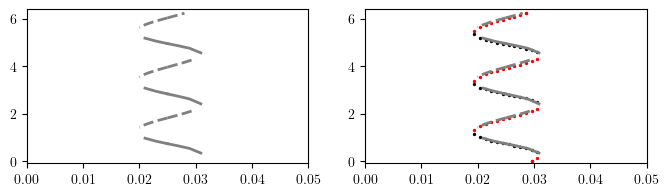

In [116]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=(0,.05,50),rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys min

In [117]:
# get min eps
es_min,phi0 = get_es_min(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_min_temp = []
for i in range(5):
    ee = es_min+0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_min_temp.append(ee)

b_min_all.append(b)
eigenvalues_min_all.append(eigenvalues_temp)
e_vals_mono_min.append(es_min_temp)
#m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.019999999999999997 1.413591090698885
phi init 1.413591090698885
Y [-0.10829235  0.22984318  0.09185282  0.40065046 -0.61056962  0.22609477  0.08991516  0.0485054   6.25193492]
mkdir ./data/thal2_23_b0=-0.02/
* Loading LC data...
self.T 6.251934941007981
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0013905464384116083
es_min,phi0 0.020499999999999997 1.413591090698885
phi init 1.413591090698885
Y [-1.09036364e-01  2.35796286e-01  9.20701026e-02  3.92962301e-01 -4.87429776e-01  6.46928543e-01  9.59205183e-02  8.58684261e-05  6.25114508e+00]
mkdir ./data/thal2_23_b1=-0.02/
* Loading LC data...
self.T 6.251145089591478
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0019474769349660346
es_min,phi0 0.020999999999999998 1.413591090698885
phi init 1.413591090698885
Y [-1.08950580e-01  2.28028658e-01  9.20469307e-02  4.02112912e-01 -4.81372198e-01  6.49927030e-01  9.57367300e-02  7.30488683e-05  6.25041629e+00]
mk

#### Monodromys max

In [118]:
# get min eps
es_max,phi0 = get_es_max(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_max_temp = []
for i in range(5):
    ee = es_max-0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_max_temp.append(ee)

b_max_all.append(b)
eigenvalues_max_all.append(eigenvalues_temp)
e_vals_mono_max.append(es_max_temp)
#m1b = get_monodromy_full(es_max+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_max+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.030900000000000004 2.412504726771953
phi init 2.412504726771953
Y [-1.08377070e-01  2.32117616e-01  9.21740207e-02  3.98009308e-01 -6.15211162e-01  4.45430180e-01  9.59534120e-02  5.94845777e-03  6.24021004e+00]
mkdir ./data/thal2_23_b0=-0.02/
* Loading LC data...
self.T 6.251934941007981
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0013905464384116083
es_min,phi0 0.030400000000000003 2.412504726771953
phi init 2.412504726771953
Y [-0.10834192  0.23092604  0.09214334  0.39942739 -0.61933054  0.42588331  0.09535794  0.00745159  6.24058575]
mkdir ./data/thal2_23_b1=-0.02/
* Loading LC data...
self.T 6.251145089591478
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0019474769349660346
es_min,phi0 0.029900000000000003 2.412504726771953
phi init 2.412504726771953
Y [-1.09759978e-01  2.22643262e-01  9.20089214e-02  4.07700293e-01 -4.01997066e-01  6.55452414e-01  9.39239419e-02  1.48787701e-05  6.24097539e+00]
mk

In [119]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

# Two parameter full

In [120]:
# fname_raw = 'thal2r_{}{}_2par_fixed.dat'
# fname = '../bifdat_2par/'+fname_raw.format(a._n[1],a._m[1])
# print(fname)
# data = np.loadtxt(fname)

fname_raw = 'thal2_{}{}_2k_o2_pos.dat'
data = np.loadtxt('../v2_bifdat_2par/redu/'+fname_raw.format(a._n[1],a._m[1]))

fname_raw = 'thal2_{}{}_2k_o2_neg.dat'
data2 = np.loadtxt('../v2_bifdat_2par/redu/'+fname_raw.format(a._n[1],a._m[1]))

fname_raw = 'thal2_{}{}_2k_o2_neg2.dat'
data3 = np.loadtxt('../v2_bifdat_2par/redu/'+fname_raw.format(a._n[1],a._m[1]))

# fname_raw = 'thal2_{}{}_2k_o2_neg3.dat'
# data4 = np.loadtxt('../v2_bifdat_2par/redu/'+fname_raw.format(a._n[1],a._m[1]))

(-0.02, 0.01)

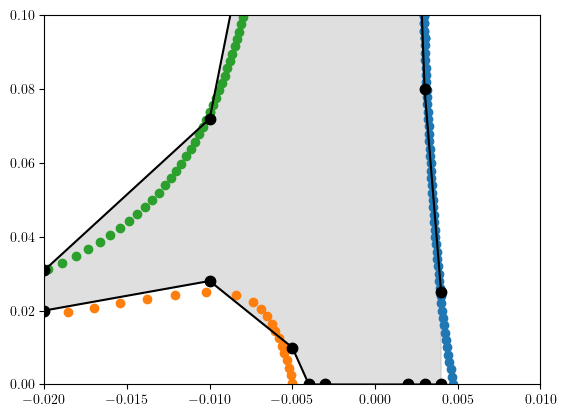

In [121]:
fig,axs = plt.subplots()
axs.fill_between(b_vals_full,e_vals_full,e_hi_full,color='gray',alpha=.25)
axs.plot(b_vals_full,e_vals_full,marker='.',color='k',markersize=15)
axs.plot(b_vals_full,e_hi_full,marker='.',color='k',markersize=15)

axs.scatter(data[:,1],data[:,0])
axs.scatter(data2[:,1],data2[:,0])
axs.scatter(data3[:,1],data3[:,0])

axs.set_ylim(0,.1)
axs.set_xlim(-.02,.01)

In [122]:
fname_lo = '../v2_bifdat_2par/full/thal2_2par_lo_{}{}.dat'.format(a._n[1],a._m[1])
fname_hi = '../v2_bifdat_2par/full/thal2_2par_hi_{}{}.dat'.format(a._n[1],a._m[1])

arr_lo = np.zeros([len(b_vals_full),2])
arr_hi = np.zeros([len(b_vals_full),2])

arr_lo[:,0] = b_vals_full
arr_lo[:,1] = e_vals_full

arr_hi[:,0] = b_vals_full
arr_hi[:,1] = e_hi_full

np.savetxt(fname_lo,arr_lo)
np.savetxt(fname_hi,arr_hi)

# Eigenvalue Convergence Plot

## Min

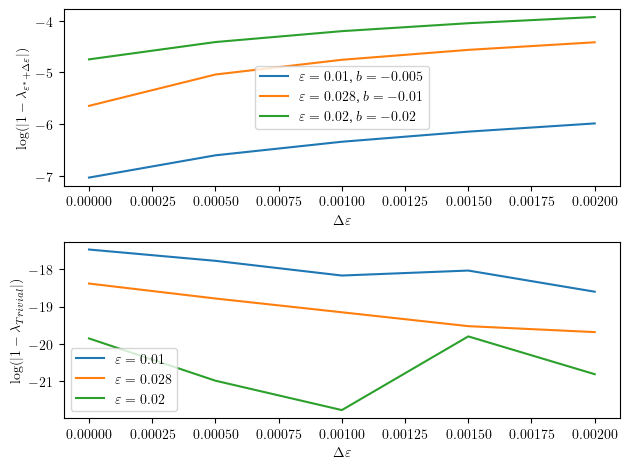

In [123]:
fig,axs = plt.subplots(2,1)

eps_values = np.arange(0,+0.0005*5,.0005)
skipn = 1

for j in range(len(eigenvalues_min_all[::skipn])):
    nn = len(eigenvalues_min_all[::skipn][j])

    at_eigen = []
    near_eigen = []
    
    for i in range(nn):
        eigenval = np.array(eigenvalues_min_all[::skipn][j][i])
        
        min1 = np.argsort(np.abs(eigenval-1))[:2]
        periodic1,bif1 = eigenval[min1]
        
        at_eigen.append(periodic1)
        near_eigen.append(bif1)

    
    ee = e_vals_mono_min[::skipn][j]
    e0 = ee[0]
    de = ee - e0
    
    axs[0].plot(eps_values,np.log(np.abs(1-np.array(near_eigen))),label=r'$\varepsilon='+str(np.round(e0,3))+r'$, ' +r'$b='+str(b_min_all[j])+r'$')
    axs[1].plot(eps_values,np.log(np.abs(1-np.array(at_eigen))),label=r'$\varepsilon='+str(np.round(e0,3))+r'$')
    #axs[1].plot(lc_list2,label='Near Bifurcation')

    axs[0].legend()
    axs[1].legend()

    axs[0].set_xlabel(r'$\Delta\varepsilon$')
    axs[1].set_xlabel(r'$\Delta\varepsilon$')
    #axs[1].set_xlabel('Point')
    
    axs[0].set_ylabel(r'$\log(|1 - \lambda_{\varepsilon^*+\Delta\varepsilon}|)$')
    axs[1].set_ylabel(r'$\log(|1-\lambda_{Trivial}|)$')

    plt.tight_layout()
    plt.savefig('../figs/supp_convergence_thal2_min_{}{}.png'.format(a._n[1],a._m[1]))

## Max

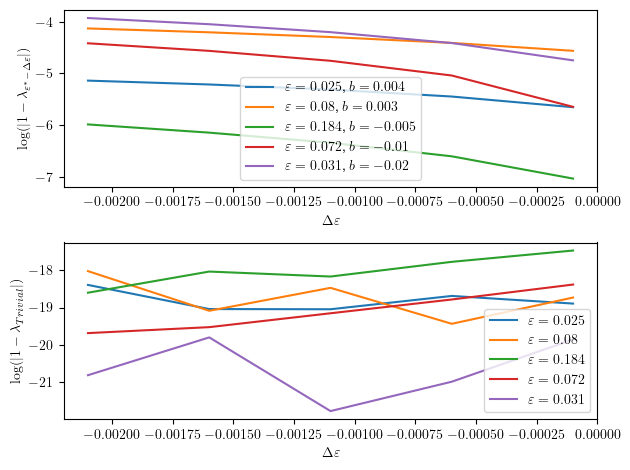

In [124]:
fig,axs = plt.subplots(2,1)

#es_min+.0001+0.0005*i
#ee = es_max-.0001-0.0005*i
eps_values = np.arange(-0.0001,0.0001-0.0005*5,-.0005)
skipn = 1

for j in range(len(eigenvalues_max_all[::skipn])):
    nn = len(eigenvalues_max_all[::skipn][j])

    at_eigen = []
    near_eigen = []
    
    for i in range(nn):
        eigenval = np.array(eigenvalues_max_all[::skipn][j][i])
        
        max1 = np.argsort(np.abs(eigenval-1))[:2]
        periodic1,bif1 = eigenval[max1]
        
        at_eigen.append(periodic1)
        near_eigen.append(bif1)

    ee = e_vals_mono_max[::skipn][j]
    e0 = ee[0]
    de = ee - e0
    
    axs[0].plot(eps_values,np.log(np.abs(1-np.array(near_eigen))),label=r'$\varepsilon='+str(np.round(e0,3))+r'$, ' +r'$b='+str(b_max_all[j])+r'$')
    axs[1].plot(eps_values,np.log(np.abs(1-np.array(at_eigen))),label=r'$\varepsilon='+str(np.round(e0,3))+r'$')
    #axs[1].plot(lc_list2,label='Near Bifurcation')

    axs[0].legend()
    axs[1].legend()

    axs[0].set_xlabel(r'$\Delta\varepsilon$')
    axs[1].set_xlabel(r'$\Delta\varepsilon$')
    #axs[1].set_xlabel('Point')
    
    axs[0].set_ylabel(r'$\log(|1 - \lambda_{\varepsilon^*-\Delta\varepsilon}|)$')
    axs[1].set_ylabel(r'$\log(|1-\lambda_{Trivial}|)$')

    plt.tight_layout()
    plt.savefig('../figs/supp_convergence_thal2_max_{}{}.png'.format(a._n[1],a._m[1]))